# SYDE 556/750 --- Assignment 2

**Student ID: 00000000**

_Note:_ Please include your numerical student ID only, do _not_ include your name.

_Note:_ Refer to the [PDF](https://github.com/tcstewar/syde556-f21/raw/master/assignments/assignment_02/syde556_assignment_02.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.


In [7120]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
s = 18945
np.random.seed(s)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Generating a random input signal

## 1.1 Band-limited white noise

**a) Time-domain signals.** Plot $x(t)$ for three randomly generated signals with $\texttt{limit}$ at $5$, $10$, and $20\,\mathrm{Hz}$. For each of these, $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$ and $\mathtt{rms}=0.5$.


In [7121]:
# SETUP
def signal_rms(signal):
    return np.sqrt(np.mean(np.power(signal, 2)))


def im_normal_rand():
    return np.random.normal() + np.random.normal() * 1j


def symmetry_exists(f, F):
    neg = -f
    return neg in F and f != 0, np.where(F == neg)


def locations(index):
    return int(index[0])


def rescale(signal, ideal_rms):
    cur_rms = signal_rms(signal)
    rescaled_signal = [p * ideal_rms / cur_rms for p in signal]
    return rescaled_signal


def zippify(F, Z):
    return (list(tt) for tt in zip(*sorted(zip(F, Z))))


def generate_signal(T, dt, rms, limit, seed):
    if seed != 0:
        np.random.seed(int(seed))
    # generate a times scale
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            magnitude_f = abs(f)
            if magnitude_f <= limit:
                im = im_normal_rand()
                Z[idx] = im
                # ensure that we account for the negative symmetric value
                exists, index = symmetry_exists(f, F)
                if exists:
                    location = locations(index)
                    # assig it to the complex conjugate
                    Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescale(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = zippify(F, Z)
    return z, Z


def plot_signal(
    signal, domain="time", T=1, dt=1 / 1000, show_rmse=True, bandwidth=False
):
    t = np.arange(0, T, dt)
    if domain == "time":
        plt.figure()
        plt.plot(t, signal["x"])
        if bandwidth:
            plt.suptitle(
                "$x(t)$ signal with " + str(signal["freq"]) + " Hz bandwidth",
            )
        else:
            plt.suptitle(
                "$x(t)$ signal with " + str(signal["freq"]) + " Hz limit",
            )
        plt.xlabel("$t$ sec.")
        plt.ylabel("$x(t)$")
        plt.xlim([0, T])
        plt.show()
        if show_rmse:
            print("time-domain RMSE " + str(np.round(signal_rms(signal["x"]), 3)))
    if domain == "frequency":
        plt.figure()
        plt.plot(t, signal["X"])
        if bandwidth:
            plt.suptitle(
                "$x(\omega)$ signal with " + str(signal["freq"]) + " Hz bandwidth",
            )
        else:
            plt.suptitle(
                "$x(\omega)$ signal with " + str(signal["freq"]) + " Hz limit",
            )
        plt.xlabel("$w$ Hz.")
        plt.ylabel("$x(\omega)$")
        plt.show()
        if show_rmse:
            print("frequency-domain RMSE " + str(np.round(signal_rms(signal["X"]), 3)))

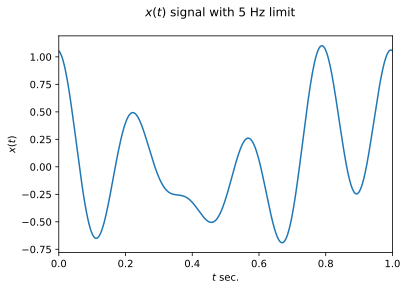

time-domain RMSE 0.5


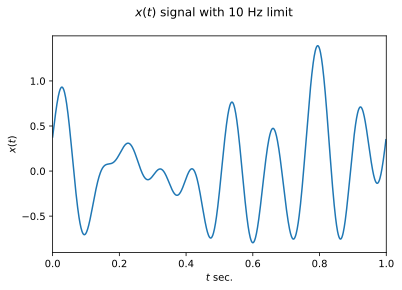

time-domain RMSE 0.5


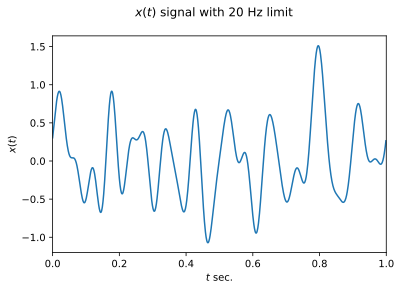

time-domain RMSE 0.5


In [7122]:
signals = []
limits = [5, 10, 20]
T = 1
dt = 1 / 1000
rms = 0.5
# Generate signals and store in list called signals as dictionaries
for limit in limits:
    x, X = generate_signal(T, dt, rms, limit, s)
    signal = {"x": x, "X": X, "freq": limit}
    signals.append(signal)

for signal in signals:
    plot_signal(signal, domain="time", T=T, dt=dt, show_rmse=True)

**b) Average power spectrum.** Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients, or “power spectrum”) over $100$ signals generated with $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=10\,\mathrm{Hz}$ (of course, each of these 100 signals should have a different `seed`). The plot should have the $x$-axis labeled “$\omega$ in radians” and the average $|X|$ value for that $\omega$ on the $y$-axis.


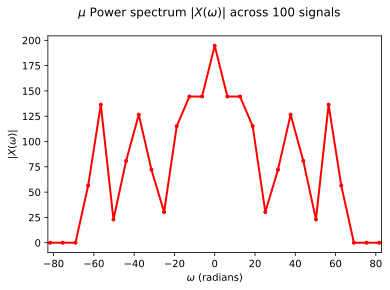

In [7123]:
num_signals = 100

signals = []
limit = 10
T = 1
dt = 1 / 1000
rms = 0.5
random_seeds = np.zeros(num_signals)


def norm(Xs):
    return [
        np.absolute(freq_vals)
        for freq_vals in Xs[
            :,
        ]
    ][0]


for idx, seed in enumerate(random_seeds):
    random_seeds[idx] = int(np.random.randint(1111, 9999))

frequency_signals = []

for lseed in random_seeds:
    x, X = generate_signal(T, dt, rms, limit, lseed)
    signal = {"x": x, "X": X, "freq": limit}
    frequency_signals.append(X)
    signals.append(signal)

timescale = np.arange(0, T, dt)
# get the number of points so that we can create a signal in the frequency domain
num_pts = len(timescale)
# convert to frequency domain
F = sorted(fft.fftfreq(num_pts, dt))

# conver to rad/s
F = np.array(F)
W = F * 2 * np.pi
W = W.tolist()
endpoints = [-2 * np.pi * limit - 20, 2 * np.pi * limit + 20]
frequency_signals = np.array(frequency_signals)
norms = norm(frequency_signals)
plt.figure()
plt.suptitle(
    "$\mu$ Power spectrum $|X(\omega)|$ across " + str(num_signals) + " signals"
)
plt.plot(W, norms, "r", linewidth=2,marker=".")
plt.xlabel("$\omega$ (radians)")
plt.ylabel("$|X(\omega)|$")
plt.xlim(endpoints)
plt.show()

## 1.2 Gaussian power spectrum noise

**a) Time-domain signals.** Plot $x(t)$ for three randomly generated signals with `bandwidth` at $5$, $10$, and $20\,\mathrm{Hz}$. For each of these, $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$ and $\mathtt{rms}=0.5$.


In [7124]:
def im_smooth_rand(omega=0, bandwidth=5):
    mu = 1
    sigma = np.exp((-1 * np.power(omega, 2)) / (2 * np.power(bandwidth, 2)))
    return np.random.normal(scale=sigma) + np.random.normal(scale=sigma) * 1j


def generate_smooth_signal(T, dt, rms, bandwidth, seed):
    if seed != 0:
        np.random.seed(int(seed))
    # generate a times scale
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            im = im_smooth_rand(omega=f, bandwidth=bandwidth)
            Z[idx] = im
            # ensure that we account for the negative symmetric value
            exists, index = symmetry_exists(f, F)
            if exists:
                location = locations(index)
                # assig it to the complex conjugate
                Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescale(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = zippify(F, Z)
    return z, Z

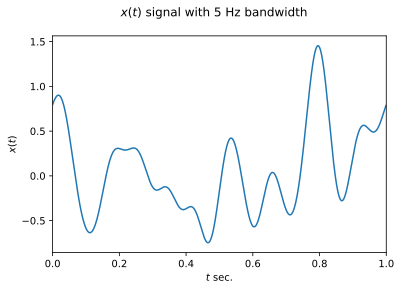

time-domain RMSE 0.5


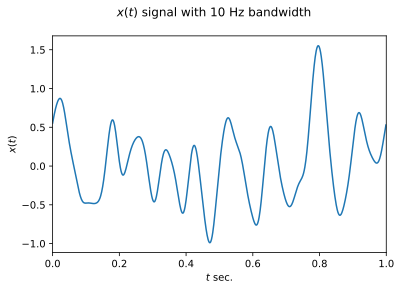

time-domain RMSE 0.5


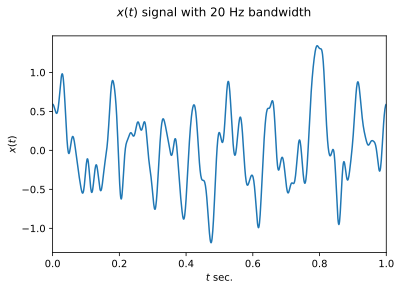

time-domain RMSE 0.5


In [7125]:
signals = []
bandwidths = [5, 10, 20]
T = 1
dt = 1 / 1000
rms = 0.5
# Generate signals and store in list called signals as dictionaries
for bw in bandwidths:
    x, X = generate_smooth_signal(T, dt, rms, bw, s)
    signal = {"x": x, "X": X, "freq": bw}
    signals.append(signal)

for signal in signals:
    plot_signal(signal, domain="time", T=T, dt=dt, show_rmse=True,bandwidth=True)

**b) Average power spectrum.** Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients, or “power spectrum”) over $100$ signals generated with $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{bandwidth}=10$ (of course, each of these 100 signals should have a different `seed`). The plot should have the $x$-axis labeled “$\omega$ in radians” and the average $|X|$ value for that $\omega$ on the $y$-axis.


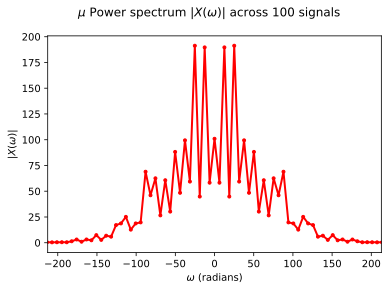

In [7126]:
num_signals = 100

signals = []
bandwidth = 10
T = 1
dt = 1 / 1000
rms = 0.5
random_seeds = np.zeros(num_signals)


for idx, seed in enumerate(random_seeds):
    random_seeds[idx] = int(np.random.randint(1111, 9999))

bandwidth_signals = []

for lseed in random_seeds:
    x, X = generate_smooth_signal(T, dt, rms, bandwidth, lseed)
    signal = {"x": x, "X": X, "freq": bandwidth}
    bandwidth_signals.append(X)
    signals.append(signal)

timescale = np.arange(0, T, dt)
# get the number of points so that we can create a signal in the frequency domain
num_pts = len(timescale)
# convert to frequency domain
F = sorted(fft.fftfreq(num_pts, dt))

# conver to rad/s
F = np.array(F)
W = F * 2 * np.pi
W = W.tolist()
endpoints = [-2 * np.pi * bandwidth - 150, 2 * np.pi * bandwidth + 150]
bandwidth_signals = np.array(bandwidth_signals)
norms = norm(bandwidth_signals)
plt.figure()
plt.suptitle(
    "$\mu$ Power spectrum $|X(\omega)|$ across " + str(num_signals) + " signals"
)
plt.plot(W, norms, "r", linewidth=2, marker=".")
plt.xlabel("$\omega$ (radians)")
plt.ylabel("$|X(\omega)|$")
plt.xlim(endpoints)
plt.show()

# 2. Simulating a spiking neuron

**a) Spike plots for constant inputs.** Plot the spike output for a constant input of $x=0$ over $1$ second. Report the number of spikes. Do the same thing for $x=1$. Use a time step of $\Delta t = 1\,\mathrm{ms}$ for the simulation.


In [7127]:
from uuid import uuid4

tau_ref = 2 / 1000
tau_rc = 20 / 1000


def gain(intercept, tau_ref, tau_rc, b):
    return 1 / (1 - np.exp((tau_ref - (1 / intercept)) / tau_rc)) - b


def bias(intercept, tau_ref, tau_rc):
    return 1 / (1 - np.exp((tau_ref - (1 / intercept)) / tau_rc))


def lif_encode(neuron, x):
    J = neuron.a * x * neuron.encoder_sign + neuron.j_bias
    if J > 1:
        return 1 / (tau_ref - tau_rc * np.log(1 - 1 / J))
    return 0


def lif_encode_2d(neuron, xy):
    J = neuron.a * np.vdot(xy, neuron.circ) + neuron.j_bias
    if J > 1:
        return 1 / (tau_ref - tau_rc * np.log(1 - 1 / J))
    return 0


def print_block(title, data):
    print(title + " ----------")
    print(data)
    print("-----------------")


class Population:
    def __init__(self, num_neurons=1, state=None):
        self.num_neurons = num_neurons
        if state == None:
            self.default_neuron_states = [
                {
                    "min_rate": 40,
                    "max_rate": 150,
                    "encoder": 1,
                    "tau_ref": 2 / 1000,
                    "tau_rc": 20 / 1000,
                }
            ]
        else:
            self.default_neuron_states = state
        self.neurons = []
        for idx in range(self.num_neurons):
            neuron = Neuron(self.default_neuron_states[idx])
            self.neurons.append(neuron)

    """ Cleans out a population """

    def nuke(self):
        self.neurons = []

    """ Applies a mutator to each neuron in the population """

    def mutate(self, mutator):
        if len(self.neurons) == 0:
            return
        else:
            for neuron in self.neurons:
                mutator(neuron)

    def spike(self, X, dT):
        O = []
        for neuron in self.neurons:
            spikes = neuron.spikies(X, dT)
            O.append(spikes)
        return O

    def get_neurons(self):
        return self.neurons

    def get_neuron(self, idx):
        return self.neurons[idx]


class Neuron(Population):
    def __init__(self, state):
        self.min_rate = state["min_rate"]
        self.max_rate = state["max_rate"]
        self.e = state["encoder"]
        self.tau_ref = state["tau_ref"]
        self.tau_rc = state["tau_rc"]
        self.j_bias = bias(self.min_rate, self.tau_ref, self.tau_rc)
        self.alpha = gain(self.max_rate, self.tau_ref, self.tau_rc, self.j_bias)
        self.id = uuid4()
        self.spiketrend = []

    def whoisthis(self):
        print(self.__dict__)

    def encode(self, x):
        return self.alpha * x * self.e + self.j_bias

    def voltage(self, J, V, dT):
        return V + (dT * (1 / self.tau_rc) * (J - V))

    def howmanyspikes(self):
        spike_points = self.spiketrend[:, 1]
        num_spikes = int(spike_points.tolist().count(1))
        return num_spikes

    def output(self):
        return self.spiketrend

    def spikies(self, X, dT):
        N = np.floor(self.tau_ref / dT)
        V_th = 1
        V_rest = 0
        spikes = np.array([np.zeros(len(X)), np.zeros(len(X))]).T
        V = V_rest
        V_prev = V_rest
        ref_period = False
        for idx, x in enumerate(X):
            if ref_period == True:
                V = V_rest
                V_prev = V_rest
                # voltage is 0
                spikes[idx][0] = 0
                # no spike so set it to 0
                spikes[idx][1] = 0
                # we have completed one ref cycle
                ref_period = False
            else:
                J = self.encode(x)
                V = self.voltage(J, V_prev, dT)
                if V >= V_th:
                    # we have a spike so assign second column to 1 to indicate a spike
                    spikes[idx][1] = int(1)
                    # start the ref period
                    ref_period = True
                    # assign the first collumn to the current voltage
                    # assign a constant spiking voltage to make identification easier
                    spikes[idx][0] = 1.25
                    # reset the voltage to 0
                    V = V_rest
                    V_prev = V_rest
                else:
                    if V < V_rest:
                        V = V_rest
                    # no spikes to assign second column to 0
                    spikes[idx][1] = int(0)
                    # still capture the voltage
                    spikes[idx][0] = V
                    # assign the previous voltage to the current voltage for next iteration
                    V_prev = V
        self.spiketrend = spikes
        return spikes

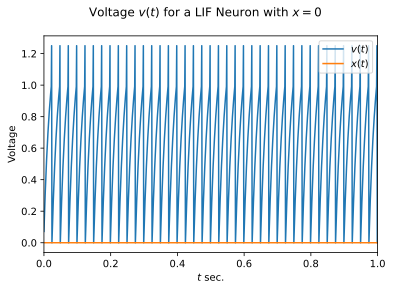

Number of Spikes with input of x=0 over 1 second ----------
40
-----------------


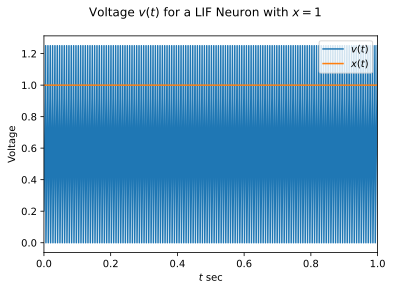

Number of Spikes with input of x=1 over 1 second ----------
143
-----------------


In [7128]:
dt = 1 / 1000
T = 1
t = np.arange(0, T, dt)
x = [0 for time in t]

state = [{
    "min_rate": 40,
    "max_rate": 150,
    "encoder": 1,
    "tau_ref": dt,
    "tau_rc": 20 / 1000,
}]
Pop = Population(1, state)


outputs = Pop.spike(x, dt)

# in this case we only have 1 neuron so:
spikes = outputs[0]
voltages = spikes[:, 0]

neuron = Pop.get_neuron(0)
num_spikes = neuron.howmanyspikes()

plt.figure()
plt.suptitle("Voltage $v(t)$ for a LIF Neuron with $x=0$")
v_plt = plt.plot(t, voltages, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()

print_block("Number of Spikes with input of x=0 over 1 second", num_spikes)

x = [1 for time in t]

outputs = Pop.spike(x, dt)

# in this case we only have 1 neuron so:
spikes = outputs[0]
voltages = spikes[:, 0]

neuron = Pop.get_neuron(0)

num_spikes = neuron.howmanyspikes()

plt.figure()
plt.suptitle("Voltage $v(t)$ for a LIF Neuron with $x=1$")
v_plt = plt.plot(t, voltages, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()

print_block("Number of Spikes with input of x=1 over 1 second", num_spikes)

**b) Discussion.** Does the observed number of spikes in the previous part match the expected number of spikes for $x=0$ and $x=1$? Why or why not? What aspects of the simulation would affect this accuracy?


For the first case, when $x=0$ we see the expected number of spikes is 40. This is what we expect as we have a minimum rate of 40Hz. However when $x=1$ It is a different story. We can see that the number of reported spikes is 143. While close to 150Hz. It is less than what we would expect, that being 150Hz. This is likely because we are still using a relatively large $\tau_{ref}$ of 1ms wich is not close to _continuious time_. The consequence of this is that the large $\tau_{ref}$ is limiting the cycle speed of the model so we can only fit so many spikes in during our 1 second interval. If we shrink the "step" value or $\tau_{ref}$ we would expect that as $\tau_{ref} \to 0: Spikes \to 150$ when $x=1$ since it is getting closer and closer to a representation of "continuous time" (knowing that it is still discrete in reality).

It stands to reason then, that as we stray farther from an accurate representation of continous time we decrease the accuracy of our model since it serves the "clock" of our model.


**c) Spike plots for white noise inputs.** Plot the spike output for $x(t)$ generated using your function from part 1.1. Use $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=30\,\mathrm{Hz}$. Overlay on this plot $x(t)$.


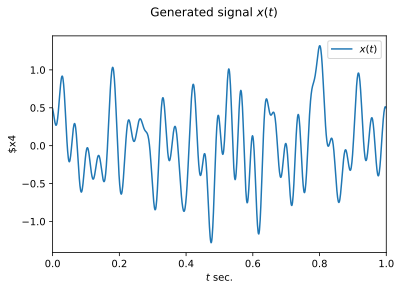

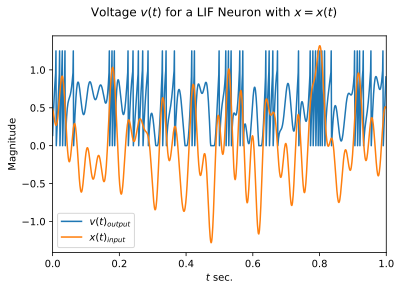

In [7129]:
T = 1
dt = 1 / 1000
rms = 0.5
limit = 30
x, X = generate_signal(T, dt, rms, limit, s)

state = [
    {
        "min_rate": 40,
        "max_rate": 150,
        "encoder": 1,
        "tau_ref": dt,
        "tau_rc": 20 / 1000,
    }
]
Pop = Population(1, state)


outputs = Pop.spike(x, dt)

# in this case we only have 1 neuron so:
spikes = outputs[0]
voltages = spikes[:, 0]

neuron = Pop.get_neuron(0)
num_spikes = neuron.howmanyspikes()

plt.figure()
plt.suptitle("Generated signal $x(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("$x4")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        x_plt,
    ],
    labels=[],
)
plt.show()

plt.figure()
plt.suptitle("Voltage $v(t)$ for a LIF Neuron with $x=x(t)$")
v_plt = plt.plot(t, voltages, label="$v(t)_{output}$")
x_plt = plt.plot(t, x, label="$x(t)_{input}$")
plt.ylabel("Magnitude")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()

**d) Voltage over time.** Using the same $x(t)$ signal as in part _c)_, plot the neuron's voltage over time for the first $0.2$ seconds, along with the spikes over the same time.


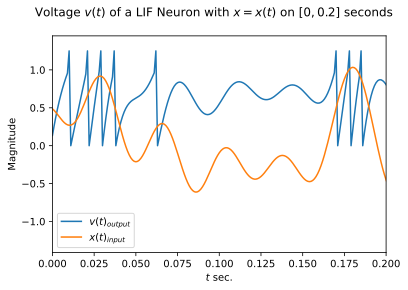

In [7130]:
plt.figure()
plt.suptitle("Voltage $v(t)$ of a LIF Neuron with $x=x(t)$ on $[0,0.2]$ seconds")
v_plt = plt.plot(t, voltages, label="$v(t)_{output}$")
x_plt = plt.plot(t, x, label="$x(t)_{input}$")
plt.ylabel("Magnitude")
plt.xlabel("$t$ sec.")
plt.xlim(0, 0.2)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()

**e) 🌟 Bonus question.** How could you improve this simulation (in terms of how closely the model matches actual equation) without significantly increasing the computation time? $0.5$ marks for having a good idea. Up to $1$ mark for actually implementing it and showing that it works.


A possible solution could be to employ a better method than Eulers's method for approximating the governing differential equation. Such a solution may be the Runge-Kutta (RK4) wich would provide a better approximation of the equation. No solution is provided (yet!)


# 3. Simulating two spiking neurons

**a) Spike plots for constant inputs.** Plot $x(t)$ and the spiking output for $x(t)=0$ (both neurons should spike at about $40$ spikes per second), as well as (in a separate plot) $x(t)=1$ (one neuron should spike at $\approx 150$ spikes per second, and the other should not spike at all).


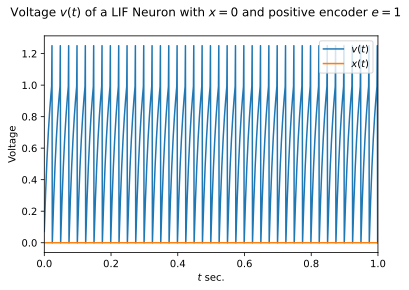

Number of Spikes for LIF neuron with positive encoder=+1 ----------
40
-----------------


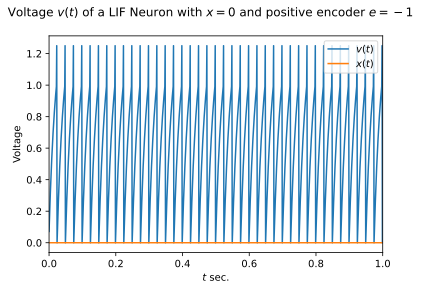

Number of Spikes for LIF neuron with negative encoder=-1 ----------
40
-----------------


In [7131]:
min_rate = 40
max_rate = 150
tau_ref = 1 / 1000
tau_rc = 20 / 1000

state = [
    {
        "min_rate": min_rate,
        "max_rate": max_rate,
        "encoder": 1,
        "tau_ref": tau_ref,
        "tau_rc": tau_rc,
    },
    {
        "min_rate": min_rate,
        "max_rate": max_rate,
        "encoder": -1,
        "tau_ref": tau_ref,
        "tau_rc": tau_rc,
    },
]
# create a population of two neurons based on the state array
# with one encoder +1 and the other -1
Pop = Population(2, state)

dt = 1 / 1000
T = 1
t = np.arange(0, T, dt)
x = [0 for time in t]

# send an input to our  population of neurons
Pop.spike(x, dt)
# our first neuron has a positive encoder +1
neuron_pos = Pop.get_neuron(0)
# out second neuron has a negative encoder -1
neuron_neg = Pop.get_neuron(1)

# get the first colum of the outputs which is the voltages
v_out_pos = neuron_pos.output()[:, 0]
v_out_neg = neuron_neg.output()[:, 0]

num_spikes_pos = neuron_pos.howmanyspikes()
num_spikes_neg = neuron_neg.howmanyspikes()


plt.figure()
plt.suptitle("Voltage $v(t)$ of a LIF Neuron with $x=0$ and positive encoder $e=1$")
v_plt = plt.plot(t, v_out_pos, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()
print_block("Number of Spikes for LIF neuron with positive encoder=+1", num_spikes_pos)

plt.figure()
plt.suptitle("Voltage $v(t)$ of a LIF Neuron with $x=0$ and positive encoder $e=-1$")
v_plt = plt.plot(t, v_out_neg, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()
print_block("Number of Spikes for LIF neuron with negative encoder=-1", num_spikes_neg)

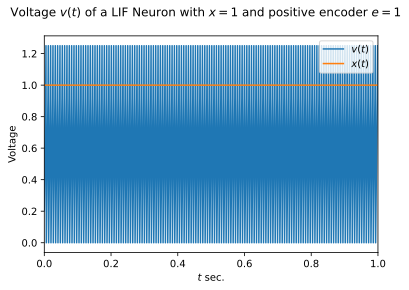

Number of Spikes for LIF neuron with positive encoder=+1 ----------
143
-----------------


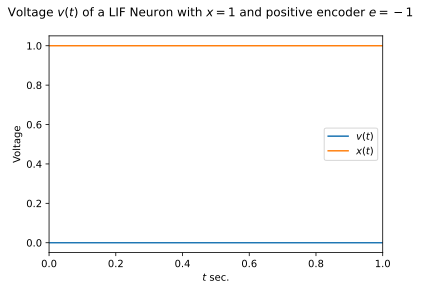

Number of Spikes for LIF neuron with negative encoder=-1 ----------
0
-----------------


In [7132]:
x = [1 for time in t]
# send an input to our  population of neurons
Pop.spike(x, dt)
# our first neuron has a positive encoder +1
neuron_pos = Pop.get_neuron(0)
# out second neuron has a negative encoder -1
neuron_neg = Pop.get_neuron(1)

# get the first colum of the outputs which is the voltages
v_out_pos = neuron_pos.output()[:, 0]
v_out_neg = neuron_neg.output()[:, 0]

num_spikes_pos = neuron_pos.howmanyspikes()
num_spikes_neg = neuron_neg.howmanyspikes()


plt.figure()
plt.suptitle("Voltage $v(t)$ of a LIF Neuron with $x=1$ and positive encoder $e=1$")
v_plt = plt.plot(t, v_out_pos, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()
print_block("Number of Spikes for LIF neuron with positive encoder=+1", num_spikes_pos)

plt.figure()
plt.suptitle("Voltage $v(t)$ of a LIF Neuron with $x=1$ and positive encoder $e=-1$")
v_plt = plt.plot(t, v_out_neg, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()
print_block("Number of Spikes for LIF neuron with negative encoder=-1", num_spikes_neg)

**b) Spike plots for a sinusodial input.** Plot $x(t)$ and the spiking output for $x(t)=\frac{1}2 \sin(10 \pi t)$.


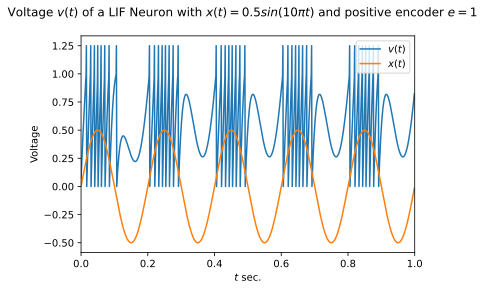

Number of Spikes for LIF neuron with positive encoder=+1 ----------
40
-----------------


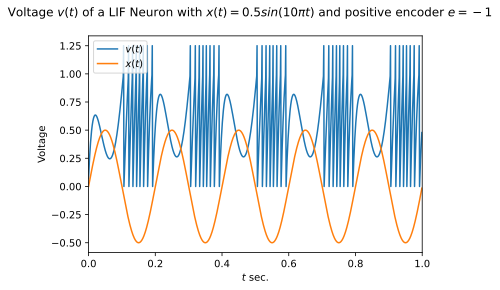

Number of Spikes for LIF neuron with negative encoder=-1 ----------
40
-----------------


In [7133]:
# generate time
t = np.arange(0, T, dt)
# generate input signal  x(t)
x = 0.5 * np.sin(10 * np.pi * t)

# send an input to our  population of neurons
Pop.spike(x, dt)
# our first neuron has a positive encoder +1
neuron_pos = Pop.get_neuron(0)
# out second neuron has a negative encoder -1
neuron_neg = Pop.get_neuron(1)

# get the first colum of the outputs which is the voltages
v_out_pos = neuron_pos.output()[:, 0]
v_out_neg = neuron_neg.output()[:, 0]

num_spikes_pos = neuron_pos.howmanyspikes()
num_spikes_neg = neuron_neg.howmanyspikes()


plt.figure()
plt.suptitle("Voltage $v(t)$ of a LIF Neuron with $x(t)=0.5sin(10\pi t)$ and positive encoder $e=1$")
v_plt = plt.plot(t, v_out_pos, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()
print_block("Number of Spikes for LIF neuron with positive encoder=+1", num_spikes_pos)

plt.figure()
plt.suptitle("Voltage $v(t)$ of a LIF Neuron with $x(t)=0.5sin(10\pi t)$ and positive encoder $e=-1$")
v_plt = plt.plot(t, v_out_neg, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()
print_block("Number of Spikes for LIF neuron with negative encoder=-1", num_spikes_neg)

**c) Spike plot for a white noise signal.** Plot $x(t)$ and the spiking output for a random signal generated with your function for question 1.1 with $\mathtt{T}=2\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=5\,\mathrm{Hz}$.


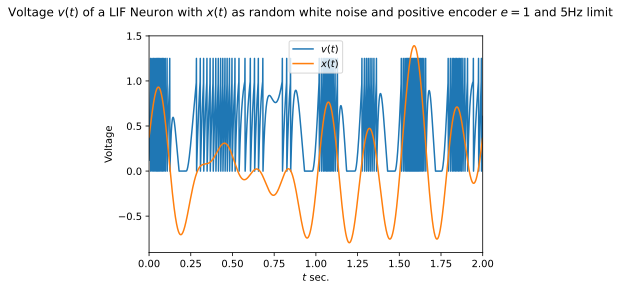

Number of Spikes for LIF neuron with positive encoder=+1 ----------
94
-----------------


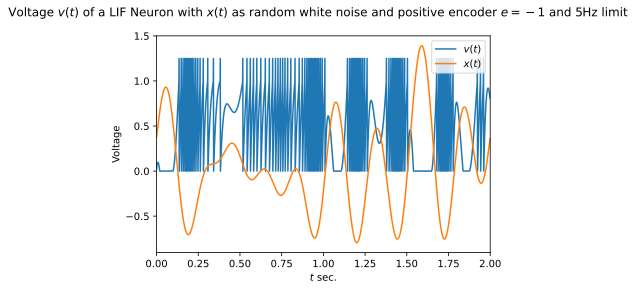

Number of Spikes for LIF neuron with negative encoder=-1 ----------
89
-----------------


In [7134]:
T = 2
dt = 1 / 1000
rms = 0.5
limit = 5
t = np.arange(0, T, dt)

x, X = generate_signal(T, dt, rms, limit, s)

sig_t = x
sig_f = X

# send an input to our  population of neurons
Pop.spike(x, dt)
# our first neuron has a positive encoder +1
neuron_pos = Pop.get_neuron(0)
# out second neuron has a negative encoder -1
neuron_neg = Pop.get_neuron(1)

# get the first colum of the outputs which is the voltages
v_out_pos = neuron_pos.output()[:, 0]
v_out_neg = neuron_neg.output()[:, 0]

spike_pos=v_out_pos
spike_neg=v_out_neg

num_spikes_pos = neuron_pos.howmanyspikes()
num_spikes_neg = neuron_neg.howmanyspikes()


plt.figure()
plt.suptitle(
    "Voltage $v(t)$ of a LIF Neuron with $x(t)$ as random white noise and positive encoder $e=1$ and 5Hz limit"
)
v_plt = plt.plot(t, v_out_pos, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()
print_block("Number of Spikes for LIF neuron with positive encoder=+1", num_spikes_pos)

plt.figure()
plt.suptitle(
    "Voltage $v(t)$ of a LIF Neuron with $x(t)$ as random white noise and positive encoder $e=-1$ and 5Hz limit"
)
v_plt = plt.plot(t, v_out_neg, label="$v(t)$")
x_plt = plt.plot(t, x, label="$x(t)$")
plt.ylabel("Voltage")
plt.xlabel("$t$ sec.")
plt.xlim(0, T)
plt.legend(
    handles=[
        v_plt,
        x_plt,
    ],
    labels=[],
)
plt.show()
print_block("Number of Spikes for LIF neuron with negative encoder=-1", num_spikes_neg)

# 4. Computing an optimal filter

**a) Document the code.** Fill in comments where there are `# !`-signs in the Python code. Make sure that your comments (where this makes sense) describe the semantics of the code and do not just repeat what is obvious from the code itself. Run the function with what you wrote for part 3 above, so that it uses the spike signal generated in 3c).


In [7135]:
def compute_optimal_filter(
    # Signal generated from your white noise generator
    x,
    # Fourier coefficients from your white noise generator
    X,
    # Spike train from the previous part
    spikes,
    # Time step size
    dt=1e-3,
):

    # x and X should (effectively) be 1D-arrays
    assert x.ndim == 1 and X.ndim == 1
    assert x.shape[0] == X.shape[0]

    # get the number of samples are going to have for our signal
    Nt = x.size

    # Make sure that "spikes" is a 2 x Nt array
    assert spikes.ndim == 2
    assert spikes.shape[0] == 2
    assert spikes.shape[1] == Nt

    # The time T is the number of samples multiplied by our step size, dt
    T = Nt * dt

    # Create a timescale centered at 0 between -1 and 1 with the timestep dt
    ts = np.arange(Nt) * dt - T / 2.0

    # create a frequency scale centered at 0 by divding the integer array of ms time samples
    # by dividing it by the inner number of steps and then twise the time range. i.e for
    # T=2s fs=[-500,...,500]
    fs = np.arange(Nt) / T - Nt / (2.0 * T)

    # convert scale from Hz to radians per second
    omega = fs * 2.0 * np.pi

    # get the difference between the positive encoder spikes and the negative encoder spikes
    r = spikes[0] - spikes[1]

    # Fourier transform the response into the frequency domain and then shift it so that it is centered at 0
    R = np.fft.fftshift(np.fft.fft(r))

    # choose the standard deviation of the filter to be 0.025
    sigma_t = 25e-3

    # use the standard deviation of sigma_t to create a Gaussian curve across the frequencies (in radians)
    W2 = np.exp(-(omega**2) * sigma_t**2)

    # Normalize so that we do not have issues when we convolve the signal
    W2 = W2 / sum(W2)

    # Find the complex cojugate of the shifted fourier transform and scale it by the the original signal input in the
    # frequency domain X
    CP = X * R.conjugate()

    # convolve the two signals, the scaled input along with the gaussian filter
    WCP = np.convolve(CP, W2, "same")

    # multiply R but its complex conjugate so that it is Real
    RP = R * R.conjugate()

    # smooth the real signal RP by convolving it with the gaussian filter. This signal should be "continuious"
    WRP = np.convolve(RP, W2, "same")

    # multiply input by its complex conjugate so that it becomes only real
    XP = X * X.conjugate()

    # smooth and make continuous the real input signal XP by convolving it with the gaussian filter
    WXP = np.convolve(XP, W2, "same")

    # this is the filter!
    H = WCP / WRP

    # move filter from frequency domain to time-domain and shift it.
    h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real

    # find the approximate frequency domain representation X_hat using filter and the frequency-domain response R
    XHAT = H * R

    # find the approximate time domain representation h_hat by inverse transforming the approx frequency response X_hat
    xhat = np.fft.ifft(np.fft.ifftshift(XHAT)).real

    return ts, fs, R, H, h, XHAT, xhat, XP, WXP

In [7136]:
# convert our inputs to np arrays since that what the function expects
x = np.array(sig_t)
X = np.array(sig_f)
dt = 1 / 1000
# create the spikes as a (2,Nt) array
spikes = np.array(
    [
        spike_pos,
        spike_neg,
    ]
)

ts, fs, R, H, h, XHAT, xhat, XP, WXP = compute_optimal_filter(x, X, spikes, dt=dt)

**b) Optimal filter.** Plot the time and frequency plots of the optimal filter for the signal you generated in question 3c). Make sure to use appropriate limits for the $x$-axis.


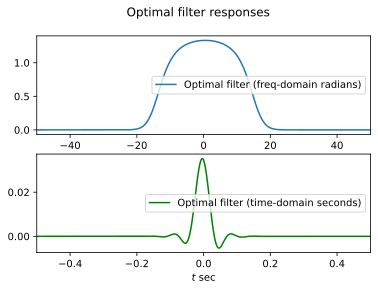

In [7137]:
plt.figure(1)
ax= plt.subplot(2, 1, 1)
plt.suptitle("Optimal filter responses")
HH = H.real
a = plt.plot(fs, HH, label="Optimal filter (freq-domain radians)")
plt.xlabel("$\omega$ radians")
plt.xlim([-50, 50])
plt.legend(
    handles=[
        a,
    ],
    labels=[],
)
plt.subplot(2, 1, 2)
b = plt.plot(ts, h, label="Optimal filter (time-domain seconds)", color="green")
plt.xlabel("$t$ sec")
plt.xlim([-0.5, 0.5])
plt.legend(
    handles=[
        b,
    ],
    labels=[],
)
plt.show()

**c) Decoded signal.** Plot the $x(t)$ signal, the spikes, and the decoded $\hat x(t)$ value for the signal from 3c).


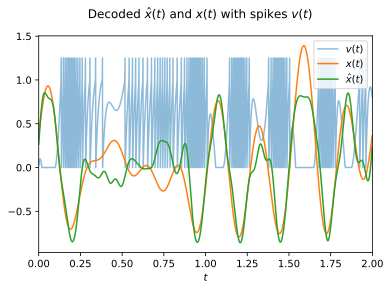

In [7138]:
r = spikes[0] = spikes[1]
plt.figure(1)
plt.suptitle("Decoded $\hat{x}(t)$ and $x(t)$ with spikes $v(t)$")
a = plt.plot(t, r, label="$v(t)$", alpha=0.5)
b = plt.plot(t, x, label="$x(t)$")
c = plt.plot(t, xhat, label="$\hat{x}(t)$")
plt.xlabel("$t$")
plt.xlim([0, T])
plt.legend(
    handles=[a, b, c],
    labels=[],
)
plt.show()

**d) Power spectra.** Plot the signal $|X(\omega)|$, spike response $|R(\omega)|$, and filtered signal $|\hat X(\omega)|$ power spectra for the signal from 3c).


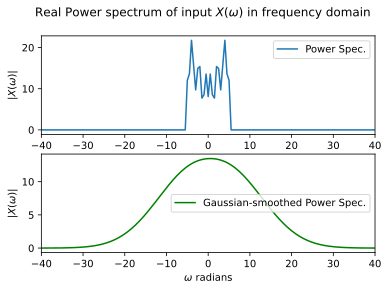

In [7139]:
plt.figure(1)
plt.subplot(2, 1, 1)
plt.suptitle("Real Power spectrum of input $X(\omega)$ in frequency domain")
xp = np.sqrt(XP.real)
a = plt.plot(fs, np.sqrt(xp), label="Power Spec.")
plt.xlabel("$\omega$ radians")
plt.ylabel("$|X(\omega)|$")
plt.xlim([-40, 40])
plt.legend(
    handles=[
        a,
    ],
    labels=[],
)
plt.subplot(2, 1, 2)
xp = np.sqrt(WXP.real)
b = plt.plot(fs, np.sqrt(xp), label="Gaussian-smoothed Power Spec.", color="green")
plt.xlabel("$\omega$ radians")
plt.ylabel("$|X(\omega)|$")
plt.xlim([-40, 40])
plt.legend(
    handles=[
        b,
    ],
    labels=[],
)
plt.show()

**e) Discussion.** How do these spectra relate to the optimal filter?


We can see from our figures that the optimal filter is helpful in reducing noise in our signal specifically between -20 and 2o radians. This can be see in outputs of the filtered spiking signal which is experiences a high rate of power dropoff as it extends beyond -20 and 20 radians in the frequency domain.


**f) Filter for different signal bandwidths.** Plot the optmial filter $h(t)$ in the time domain when filtering spike trains for white noise signals with different `limit` values of $2\,\mathrm{Hz}$, $10\,\mathrm{Hz}$, and $30\,\mathrm{Hz}$.


<Figure size 432x288 with 0 Axes>

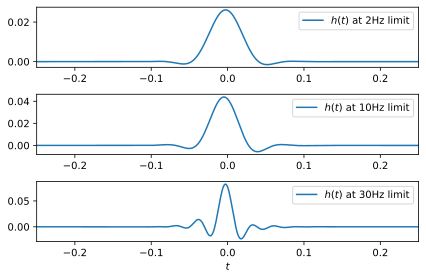

In [7140]:
def get_optimal_filter(limit=2):
    T = 2
    dt = 1 / 1000
    rms = 0.5
    t = np.arange(0, T, dt)
    x, X = generate_signal(T, dt, rms, limit, s)
    sig_t = x
    sig_f = X
    Pop.spike(x, dt)
    neuron_pos = Pop.get_neuron(0)
    neuron_neg = Pop.get_neuron(1)
    v_out_pos = neuron_pos.output()[:, 0]
    v_out_neg = neuron_neg.output()[:, 0]
    spike_pos = v_out_pos
    spike_neg = v_out_neg
    # convert our inputs to np arrays since that what the function expects
    x = np.array(sig_t)
    X = np.array(sig_f)
    dt = 1 / 1000
    # create the spikes as a (2,Nt) array
    spikes = np.array(
        [
            spike_pos,
            spike_neg,
        ]
    )
    ts, fs, R, H, h, XHAT, xhat, XP, WXP = compute_optimal_filter(x, X, spikes, dt=dt)
    return h, ts


filters = []
limits = [2, 10, 30]
for limit in limits:
    h, ts = get_optimal_filter(limit)
    filters.append({"h": h, "limit": limit, "ts": ts})

plt.figure(1)
fig, ax = plt.subplots(3, 1)
for idx, filter in enumerate(filters):
    a = ax[idx].plot(
        filter["ts"],
        filter["h"],
        label="$h(t)$ at " + str(filter["limit"]) + "Hz limit",
    )
    ax[idx].axis(xmin=-0.25, xmax=0.25)
    ax[idx].legend(handles=[a], labels=[])
    plt.xlabel("$t$")
fig.tight_layout(pad=1.0)
plt.show()

**g) Discussion.** Describe the effects on the time plot of the optimal filter as `limit` increases. Why does this happen?


As the limit increases we can see that the time plot of the filter becomes "tigher" that is it attenuates at a greater rate as it moves away from the center in either the positive or negative direction. This is because as the fequency increases the time window will decrease. This is so that when the filter is convolved with the signal in the time-domain the appropraite filter is applied. Another way of thinking of it is that at a higher frequency our signal is "faster" so perform such a convolution we want to integrate over a shorter region for a given part of the signal.


# Using post-synaptic currents as a filter

**a) Plotting the filter for different $n$.** Plot the normalized $h(t)$ for $n=0$, $1$, and $2$, with $\tau=7\,\mathrm{ms}$.


<Figure size 432x288 with 0 Axes>

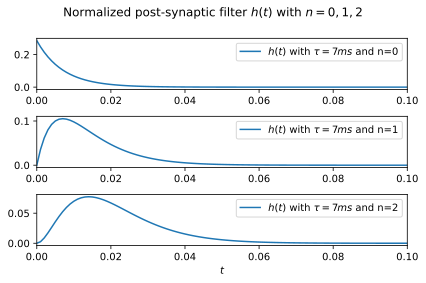

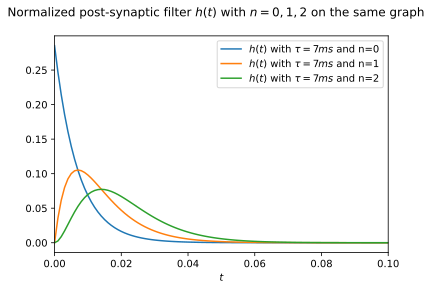

In [7141]:
def post_synaptic_current_filter(T=1, dt=1 / 1000, n=0, tau=7 / 1000):
    # assume that t is always greater than 0 in this case
    t = np.arange(0, T, dt)
    areas = []
    for pt in t:
        val = np.power(pt, n) * np.exp(-pt / tau)
        areas.append(val)
    # perform the piecewise intergration as a Reimann sum for approx estimate of c
    c = np.trapz(areas, dx=dt)
    h = np.power(c, -1) * np.power(t, n) * np.exp(-t / tau) / (0.25 * len(t))
    return h, t


dt = 1 / 1000
tau = 7 / 1000
n_vals = [0, 1, 2]
filters = []
for n in n_vals:
    h, t = post_synaptic_current_filter(T=T, dt=dt, n=n, tau=tau)
    filters.append({"h": h, "t": t, "n": n})

plt.figure(1)
fig, ax = plt.subplots(3, 1)
fig.suptitle("Normalized post-synaptic filter $h(t)$ with $n=0,1,2$")
for idx, filter in enumerate(filters):
    a = ax[idx].plot(
        filter["t"],
        filter["h"],
        label="$h(t)$ with $\\tau=7ms$ and n=" + str(filter["n"]),
    )
    ax[idx].axis(xmin=0, xmax=0.1)
    ax[idx].legend(handles=[a], labels=[])
    plt.xlabel("$t$")
fig.tight_layout(pad=1.0)
plt.show()

# show all on the same graph since it is easer to visualize...
plt.figure(2)
plt.suptitle("Normalized post-synaptic filter $h(t)$ with $n=0,1,2$ on the same graph")
handles = []
for idx, filter in enumerate(filters):
    a = plt.plot(
        filter["t"],
        filter["h"],
        label="$h(t)$ with $\\tau=7ms$ and n=" + str(filter["n"]),
    )
    handles.append(a)
plt.legend(handles=handles, labels=[])
plt.xlabel("$t$")
plt.xlim([0, 0.1])
plt.show()

**b) Discussion.** What two things do you expect increasing $n$ will do to $\hat{x}(t)$?


Increasing $n$ (the order of the filter) will cause  the peak magnitude of the filter to decrease as it increases. It will also cause a delay of the filter window in the direction of positive time. As a result $\hat{x}$ experiences a delayed peak magnitude as well, and a smoother onset.

**c) Plotting the filter for different $\tau$.** Plot the normalized $h(t)$ for $\tau=2\,\mathrm{ms}$, $\tau=5\,\mathrm{ms}$, $\tau=10\,\mathrm{ms}$, $\tau=20\,\mathrm{ms}$ with $n = 0$.


<Figure size 432x288 with 0 Axes>

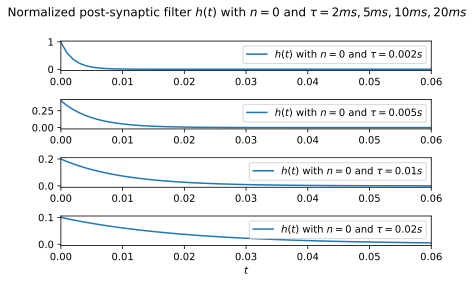

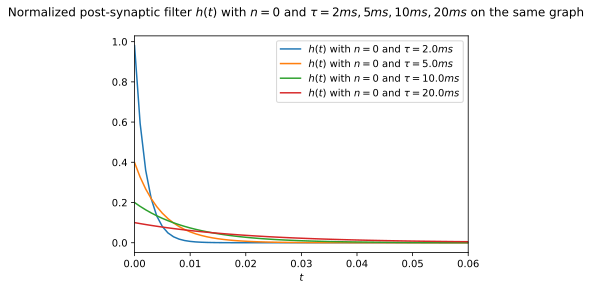

In [7142]:
dt = 1 / 1000
n = 0
tau_vals = [2 / 1000, 5 / 1000, 10 / 1000, 20 / 1000]
filters = []
for tau in tau_vals:
    h, t = post_synaptic_current_filter(T=T, dt=dt, n=n, tau=tau)
    filters.append({"h": h, "t": t, "tau": tau})

plt.figure(1)
fig, ax = plt.subplots(4, 1)
fig.suptitle(
    "Normalized post-synaptic filter $h(t)$ with $n=0$ and $\\tau=2ms,5ms,10ms,20ms$"
)
for idx, filter in enumerate(filters):
    a = ax[idx].plot(
        filter["t"],
        filter["h"],
        label="$h(t)$ with $n=0$ and $\\tau=" + str(filter["tau"]) + "s$",
    )
    ax[idx].axis(xmin=0, xmax=0.06)
    ax[idx].legend(handles=[a], labels=[])
    plt.xlabel("$t$")
fig.tight_layout(pad=1.0)
plt.show()

# show all on the same graph since it is easer to visualize...
plt.figure(2)
plt.suptitle(
    "Normalized post-synaptic filter $h(t)$ with $n=0$ and $\\tau=2ms,5ms,10ms,20ms$ on the same graph"
)
handles = []
for idx, filter in enumerate(filters):
    a = plt.plot(
        filter["t"],
        filter["h"],
        label="$h(t)$ with $n=0$ and $\\tau=" + str(filter["tau"] * 1000) + "ms$",
    )
    handles.append(a)
plt.legend(handles=handles, labels=[])
plt.xlabel("$t$")
plt.xlim([0, 0.06])
plt.show()

**d) Discussion.** What two things do you expect increasing $\tau$ will do to $\hat{x}(t)$?


Increasing $\tau$ will suppress higher frequency components of the signal and smoothes it. We can see that the window drop-off with a higher $\tau$ is much less steep than in the case with a smaller $\tau$ this would cause a smoother signal because of the winder window.


**e) Decoding a spike-train using the post-synaptic current filter.** Decode $\hat{x}(t)$ from the spikes generated in question 3c) using an $h(t)$ with $n=0$ and $\tau=7\,\mathrm{ms}$. Do this by generating the spikes, filtering them with $h(t)$, and using that as your activity matrix $A$ to compute your decoders. Plot the time and frequency plots for this $h(t)$. Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.


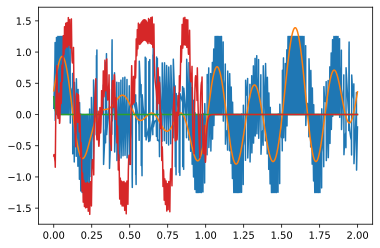

In [7143]:
def apply_filter(r, h):
    # create a signal of length r
    r_hat = np.array(np.zeros(len(r)))
    for idx, pt in enumerate(r_hat):
        V_th = 1
        if r[idx] >= V_th:
            # we hav a spike so perform a convolution
            print("spike")
        else:
            r_hat[idx] = r[idx]

    return r_hat


# from 3c
T = 2
dt = 1 / 1000
rms = 0.5
limit = 5
tau = 7 / 1000
t = np.arange(0, T, dt)
x, X = generate_signal(T, dt, rms, limit, s)


# send an input to our  population of neurons
Pop.spike(x, dt)
# our first neuron has a positive encoder +1
neuron_pos = Pop.get_neuron(0)
# out second neuron has a negative encoder -1
neuron_neg = Pop.get_neuron(1)

# get the first colum of the outputs which is the voltages
v_out_pos = neuron_pos.output()[:, 0]
v_out_neg = neuron_neg.output()[:, 0]

# checking that they are reflections of themselves
assert v_out_neg.all() == -1 * v_out_pos.all()

spikes = np.array([v_out_pos, v_out_neg])
r = spikes[0] - spikes[1]

spikes = np.array([v_out_pos, v_out_neg])
h, t = post_synaptic_current_filter(T=T, dt=dt, n=0, tau=tau)
r_hat = np.convolve(r, h, "same")
plt.figure()
plt.plot(t, r)
plt.plot(t, x)
plt.plot(t, h)
plt.plot(t, r_hat)

**f) Deocding a spike-train representing a low-frequency signal.** Use the same decoder and $h(t)$ as in part e), but generate a new $x(t)$ with $\mathtt{limit}=2\,\mathrm{Hz}$. Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.


In [7144]:
# ✍ <YOUR SOLUTION HERE>

**g) Discussion.** How do the decodings from e) and f) compare? Explain.


✍ \<YOUR SOLUTION HERE\>
